In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [33]:
# Path to your SPSS file from SOEP repository
file_path = "/path/to/your/data/pl.sav"

# Specify columns to read
usecols = ['syear','pli0043_h', 'pid', 'pli0040', 'pli0049_h','ple0040', 'hid', 'pld0152','ple0008']

df1 = pd.read_spss(file_path, usecols=usecols)

# Downcast data types to reduce memory usage
df1[usecols] = df1[usecols].apply(pd.to_numeric, errors='coerce', downcast='float')

# Replace values less than 0 with NaN
df1 = df1.applymap(lambda x: np.nan if isinstance(x, (int, float)) and x < 0 else x)

# Sort by 'pid' and then by 'syear'
df1 = df1.sort_values(by=['pid', 'syear'])

# Remove disabled individuals
df1 = df1[df1['ple0040'] != 1]

# Rename columns
df1.rename(columns={'pli0043_h': 'chores_hours', 'pli0040': 'errands_hours', 'pli0049_h': 'repairs_hours', 'pld0152': 'childbirth', 'ple0008': 'health'}, inplace=True)

# Filter for years between 2011 and 2021
df1 = df1[(df1['syear'] >= 2011) & (df1['syear'] <= 2021)]

In [36]:
#load SOEP dataset
file_path = "/path/to/your/data/ppathl.sav"

use_cols = ['pid', 'sex', 'gebjahr', 'syear', 'hid']  # Add 'syear' to the columns to read
            
df2 = pd.read_spss(file_path, usecols=use_cols)

df2 = df2.drop_duplicates(subset=['pid', 'syear'])  # Consider duplicates for each survey year

# Calculate age based on survey year
df2['age_at_survey'] = df2['syear'] - df2['gebjahr']

# Filter for age between 24 and 62 at the time of the survey
df2_filtered_age = df2[(df2['age_at_survey'] >= 18) & (df2['age_at_survey'] <= 66)]

# filter syear from 2011 to 2021
df2_filtered_age = df2_filtered_age[(df2_filtered_age['syear'] >= 2011) & (df2_filtered_age['syear'] <= 2021)]

# make sex column responses 1 for  [1] Male 2 for [2] Female
# Assuming your DataFrame is df2_filtered_age
df2_filtered_age['sex'] = df2_filtered_age['sex'].replace({'[1] Male': 1, '[2] Female': 2})

#load SOEP dataset
file_path = "/path/to/your/data/hbrutto.sav"

use_cols = ['hid', 'syear', 'hhgr']

df3 = pd.read_spss(file_path, usecols=use_cols)

# Replace specific hhgr values with NaN
df3['hhgr'] = df3['hhgr'].replace({
    '[0] Terminated/untreated HH': np.nan,
    '[-1] No Answer': np.nan,
    '[-2] Does Not Apply': np.nan,
    '[-3] Answer Improbable': np.nan,
    '[-4] Inadmissible Multiple Answer': np.nan,
    '[-5] Not Contained In Questionnaire': np.nan,
    '[-6] Questionnaire Version With Modified Filtering': np.nan
})

# Downcast data types to reduce memory usage
df3[use_cols] = df3[use_cols].apply(pd.to_numeric, errors='coerce', downcast='integer')

# Filter for years between 2011 and 2021
df3 = df3[(df3['syear'] >= 2011) & (df3['syear'] <= 2021)]

# Convert 'hid' and 'syear' to numeric types in both DataFrames
df2_filtered_age['hid'] = pd.to_numeric(df2_filtered_age['hid'], errors='coerce')
df2_filtered_age['syear'] = pd.to_numeric(df2_filtered_age['syear'], errors='coerce')

df3['hid'] = pd.to_numeric(df3['hid'], errors='coerce')
df3['syear'] = pd.to_numeric(df3['syear'], errors='coerce')

#merge df2 and df4 on hid
df_merge = df2_filtered_age.merge(df3, on= ['hid', 'syear'], how= 'outer')

#print(df_merge)

# Merge the two DataFrames on 'pid'
df4 = df_merge.merge(df1, on= ['pid', 'syear'])
df4.reset_index(inplace=True)

# add chores_hours, errands_hours, repairs_hours to housework_hours
df4['avg_housework_per_day'] = df4['chores_hours'] + df4['errands_hours'] + df4['repairs_hours']

#load csv file as dataframe
covariates_df = pd.read_csv("/path/to/your/directory/N.covariates.csv")

# drop columns from df4 hid_y, index, health, gebjahr, ple0040, errands_hours, childbirth, chores_hours, repairs_hours
df4.drop(['hid_y', 'index', 'health', 'gebjahr', 'ple0040', 'errands_hours', 'childbirth', 'chores_hours', 'repairs_hours'], axis=1, inplace=True)

# restrict df4 to syear 2011 and 2012
df4 = df4[(df4['syear'] == 2011) | (df4['syear'] == 2012)]

# merge covariates_df with df4 on pid and syear
df4 = df4.merge(covariates_df, on=['pid', 'syear'], how='left')

C:\Users\purti\AppData\Local\Temp\ipykernel_9108\4078487257.py:65: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  covariates_df = pd.read_csv(r"C:\Users\purti\Downloads\Thesis codes\N.covariates.csv")


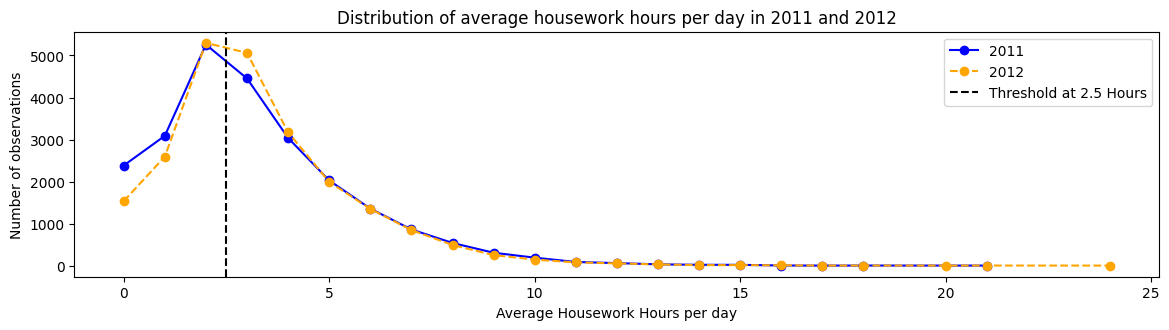

In [32]:
# Filter data for 2011 and 2012
data_2011 = df4[df4['syear'] == 2011]
data_2012 = df4[df4['syear'] == 2012]

# Group by avg_housework_per_day and count number of individuals
grouped_2011_basic = data_2011.groupby('avg_housework_per_day').size()
grouped_2012_basic = data_2012.groupby('avg_housework_per_day').size()

plt.figure(figsize=(14, 7))

# 2011 Basic Plot
plt.subplot(2, 1, 1)
plt.plot(grouped_2011_basic.index, grouped_2011_basic.values, label='2011', marker='o', color='blue')
plt.plot(grouped_2012_basic.index, grouped_2012_basic.values, label='2012', marker='o', linestyle='--', color='orange')

# Threshold line at 2.5 hours
plt.axvline(x=2.5, color='black', linestyle='--', label='Threshold at 2.5 Hours')

plt.title('Distribution of average housework hours per day in 2011 and 2012')
plt.xlabel('Average Housework Hours per day')
plt.ylabel('Number of observations')
plt.legend()

In [30]:
# Create a new column 'age_cohort' based on the 'age_at_survey' column

# Define age cohorts
bins = [18, 30, 40, 50, 60, 67]
labels = ['18-29', '30-39', '40-49', '50-59', '60-66']

# Create age_cohort for the original DataFrame
df4['age_cohort'] = pd.cut(df4['age_at_survey'], bins=bins, labels=labels, right=False)

# If data_2011 and data_2012 are slices of df4, make a copy first to avoid SettingWithCopyWarning
data_2011 = data_2011.copy()
data_2012 = data_2012.copy()

# Now assign the age_cohort to these copies
data_2011['age_cohort'] = pd.cut(data_2011['age_at_survey'], bins=bins, labels=labels, right=False)
data_2012['age_cohort'] = pd.cut(data_2012['age_at_survey'], bins=bins, labels=labels, right=False)

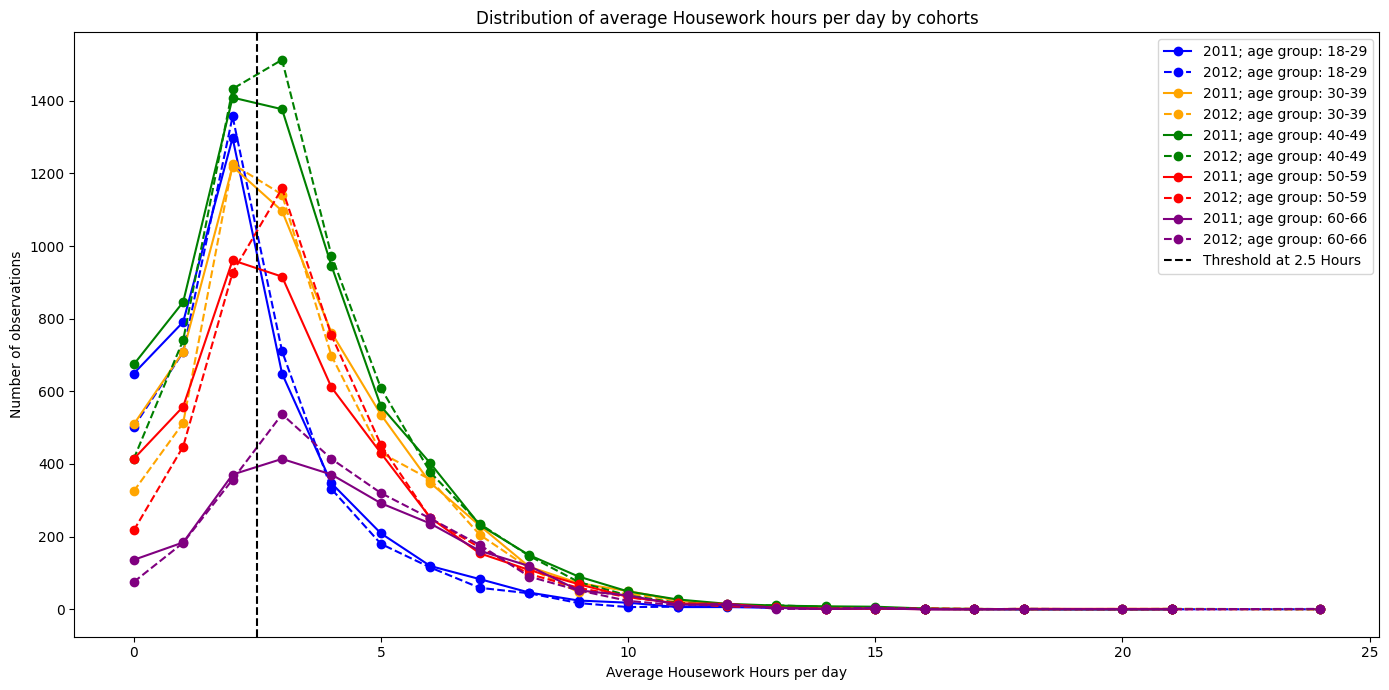

In [31]:
# Group by avg_housework_per_day and age cohort
grouped_2011 = data_2011.groupby(['avg_housework_per_day', 'age_cohort']).size().unstack(fill_value=0)
grouped_2012 = data_2012.groupby(['avg_housework_per_day', 'age_cohort']).size().unstack(fill_value=0)

plt.figure(figsize=(14, 7))
colors = ['blue', 'orange', 'green', 'red', 'purple']

for i, label in enumerate(labels):
    # 2011 Data
    # 2011 Data
    plt.plot(grouped_2011.index, grouped_2011[label], label=f'2011; age group: {label}', color=colors[i], marker='o')
    
    # 2012 Data
    plt.plot(grouped_2012.index, grouped_2012[label], label=f'2012; age group: {label}', linestyle='--', color=colors[i], marker='o')

# Threshold line at 2.5 hours
plt.axvline(x=2.5, color='black', linestyle='--', label='Threshold at 2.5 Hours')

# Titles and Labels
plt.title('Distribution of average Housework hours per day by cohorts')
plt.xlabel('Average Housework Hours per day')
plt.ylabel('Number of observations')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

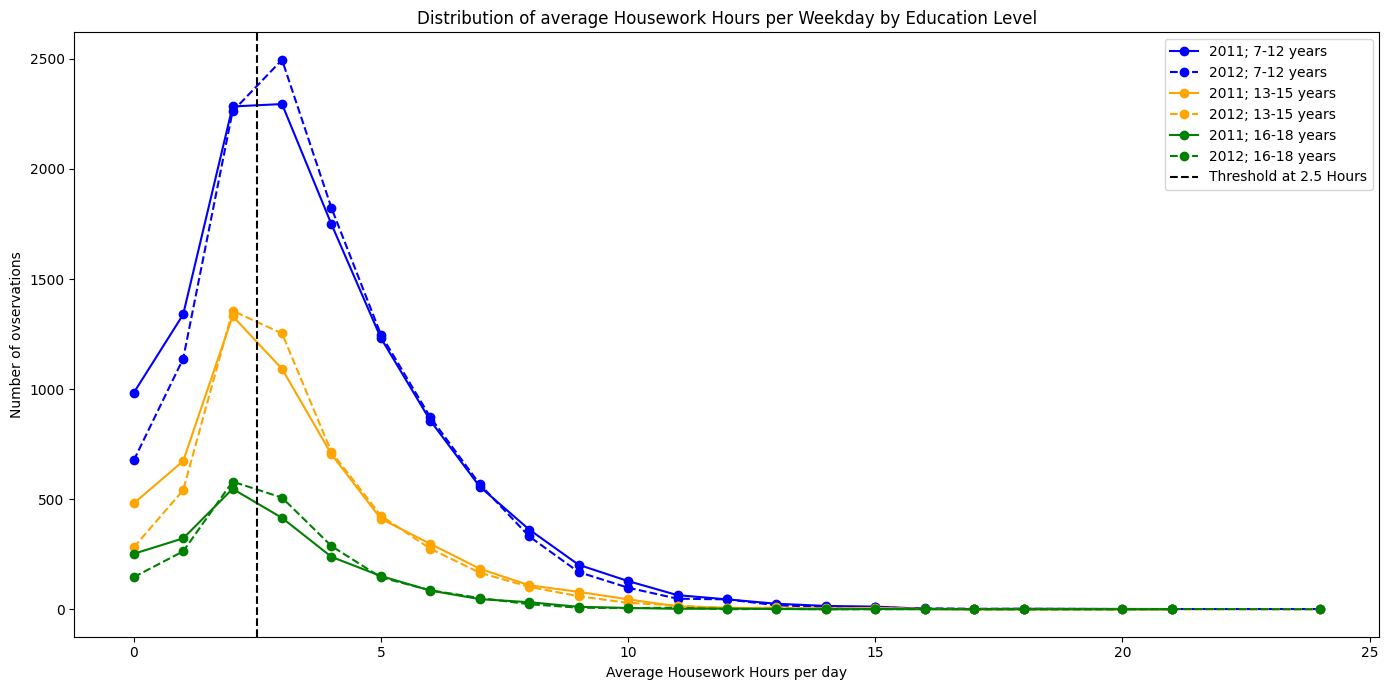

In [14]:
# Filter data for 2011 and 2012
data_2011 = df4[df4['syear'] == 2011].copy()
data_2012 = df4[df4['syear'] == 2012].copy()

# Create education cohorts using the specified bins and labels
education_bins = [6, 12, 15, 18]  # Adjusted bins for education levels
education_labels = ['7-12', '13-15', '16-18']

# Apply the bins to create a new column 'education_cohort' in the main DataFrame
df4['education_cohort'] = pd.cut(df4['education'], bins=education_bins, labels=education_labels, right=False)

# Ensure the slices also contain the education_cohort without triggering the warning
data_2011.loc[:, 'education_cohort'] = pd.cut(data_2011['education'], bins=education_bins, labels=education_labels, right=False)
data_2012.loc[:, 'education_cohort'] = pd.cut(data_2012['education'], bins=education_bins, labels=education_labels, right=False)

# Group by avg_housework_per_day and education cohort
grouped_2011 = data_2011.groupby(['avg_housework_per_day', 'education_cohort']).size().unstack(fill_value=0)
grouped_2012 = data_2012.groupby(['avg_housework_per_day', 'education_cohort']).size().unstack(fill_value=0)

# Plotting
plt.figure(figsize=(14, 7))
colors = ['blue', 'orange', 'green', 'red']

for i, label in enumerate(education_labels):
    # 2011 Data
    plt.plot(grouped_2011.index, grouped_2011[label], label=f'2011; {label} years', color=colors[i], marker='o')
    
    # 2012 Data
    plt.plot(grouped_2012.index, grouped_2012[label], label=f'2012; {label} years', linestyle='--', color=colors[i], marker='o')

# Threshold line at 2.5 hours
plt.axvline(x=2.5, color='black', linestyle='--', label='Threshold at 2.5 Hours')

# Titles and Labels
plt.title('Distribution of average Housework Hours per day by Education Level')
plt.xlabel('Average Housework Hours per day')
plt.ylabel('Number of ovservations')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


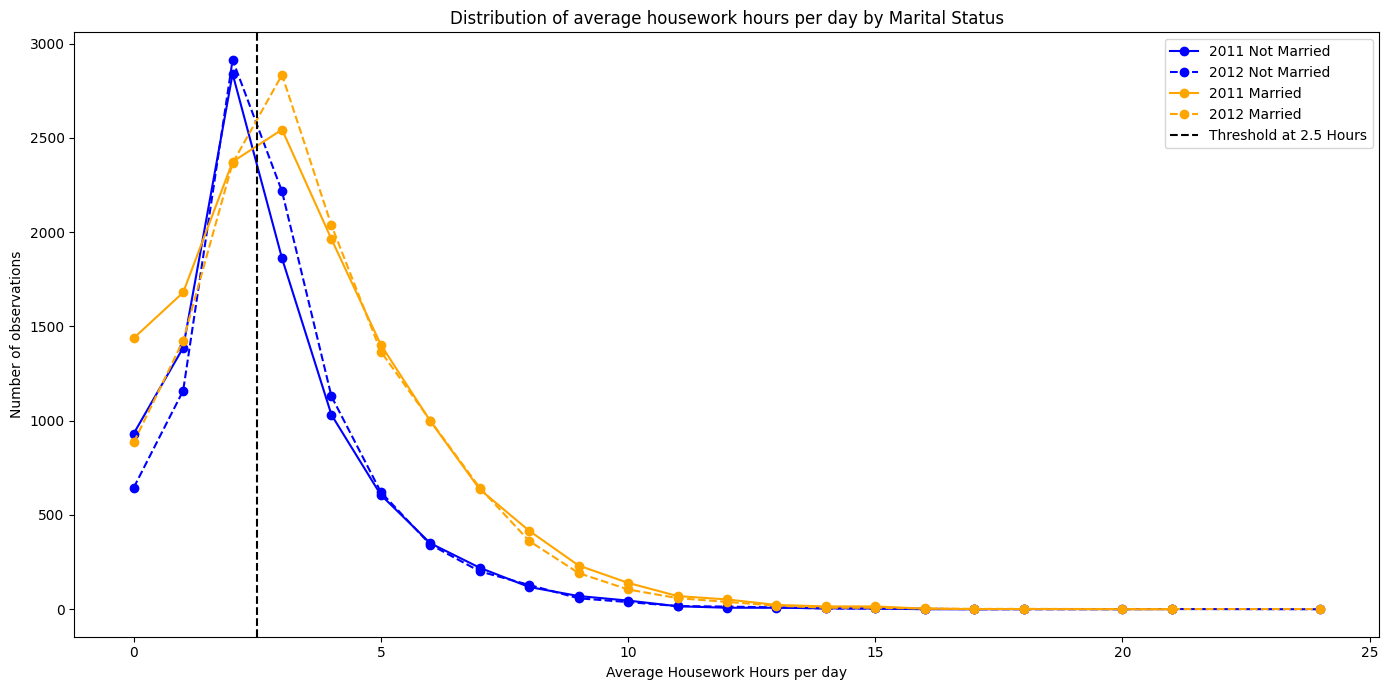

In [15]:
# Filter data for 2011 and 2012
data_2011 = df4[df4['syear'] == 2011].copy()
data_2012 = df4[df4['syear'] == 2012].copy()

# Define marital status labels
marital_status_labels = ['Not Married', 'Married']

# Ensure the slices have the marital status column properly labeled
data_2011['marital_status'] = data_2011['marital_status'].map({0: 'Not Married', 1: 'Married'})
data_2012['marital_status'] = data_2012['marital_status'].map({0: 'Not Married', 1: 'Married'})

# Group by avg_housework_per_day and marital status
grouped_2011 = data_2011.groupby(['avg_housework_per_day', 'marital_status']).size().unstack(fill_value=0)
grouped_2012 = data_2012.groupby(['avg_housework_per_day', 'marital_status']).size().unstack(fill_value=0)

# Plotting
plt.figure(figsize=(14, 7))
colors = ['blue', 'orange']

for i, label in enumerate(marital_status_labels):
    # 2011 Data
    plt.plot(grouped_2011.index, grouped_2011[label], label=f'2011 {label}', color=colors[i], marker='o')
    
    # 2012 Data
    plt.plot(grouped_2012.index, grouped_2012[label], label=f'2012 {label}', linestyle='--', color=colors[i], marker='o')

# Threshold line at 2.5 hours
plt.axvline(x=2.5, color='black', linestyle='--', label='Threshold at 2.5 Hours')

# Titles and Labels
plt.title('Distribution of average housework hours per day by Marital Status')
plt.xlabel('Average Housework Hours per day')
plt.ylabel('Number of observations')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


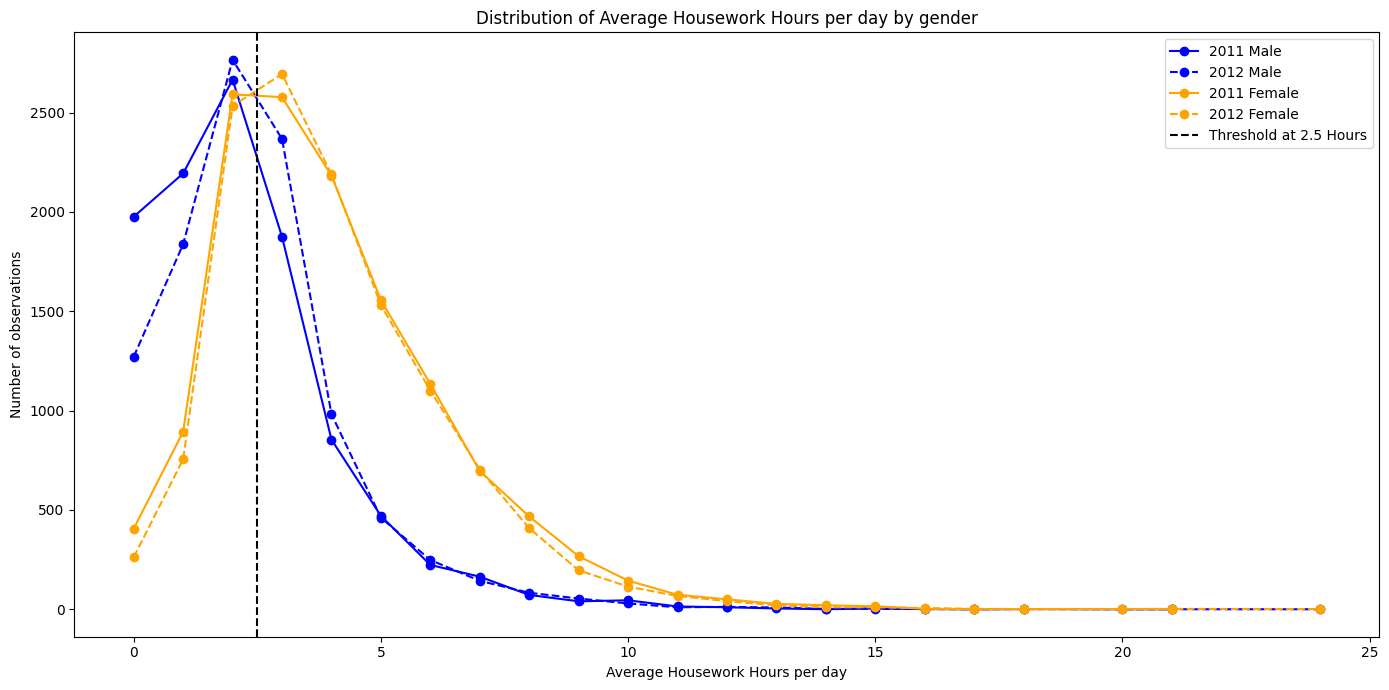

In [16]:
# Filter data for 2011 and 2012
data_2011 = df4[df4['syear'] == 2011].copy()
data_2012 = df4[df4['syear'] == 2012].copy()

# Define sex labels
sex_labels = ['Male', 'Female']

# Ensure the slices have the sex column properly labeled
data_2011['sex'] = data_2011['sex'].map({1: 'Male', 2: 'Female'})
data_2012['sex'] = data_2012['sex'].map({1: 'Male', 2: 'Female'})

# Group by avg_housework_per_day and sex
grouped_2011 = data_2011.groupby(['avg_housework_per_day', 'sex']).size().unstack(fill_value=0)
grouped_2012 = data_2012.groupby(['avg_housework_per_day', 'sex']).size().unstack(fill_value=0)

# Plotting
plt.figure(figsize=(14, 7))
colors = ['blue', 'orange']

for i, label in enumerate(sex_labels):
    # 2011 Data
    plt.plot(grouped_2011.index, grouped_2011[label], label=f'2011 {label}', color=colors[i], marker='o')
    
    # 2012 Data
    plt.plot(grouped_2012.index, grouped_2012[label], label=f'2012 {label}', linestyle='--', color=colors[i], marker='o')

# Threshold line at 2 hours
plt.axvline(x=2.5, color='black', linestyle='--', label='Threshold at 2.5 Hours')

# Titles and Labels
plt.title('Distribution of Average Housework Hours per day by gender')
plt.xlabel('Average Housework Hours per day')
plt.ylabel('Number of observations')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


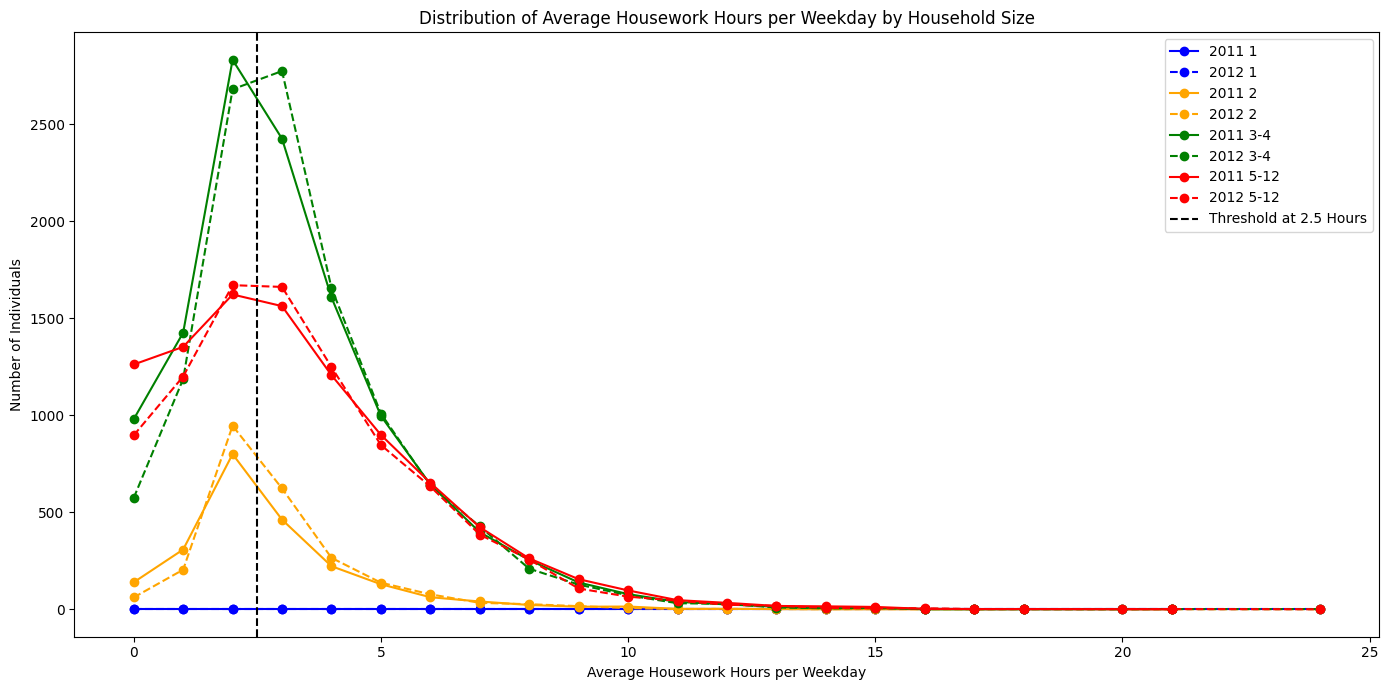

In [17]:
# Filter data for 2011 and 2012
data_2011 = df4[df4['syear'] == 2011].copy()
data_2012 = df4[df4['syear'] == 2012].copy()

# Define household size bins and labels
hhgr_bins = [0, 1, 2, 4, 12]  # Bins for household size
hhgr_labels = ['1','2', '3-4', '5-12']

# Apply the bins to create a new column 'hhgr_cohort' in the main DataFrame
df4['hhgr_cohort'] = pd.cut(df4['hhgr'], bins=hhgr_bins, labels=hhgr_labels, right=False)

# Ensure the slices also contain the hhgr_cohort without triggering the warning
data_2011['hhgr_cohort'] = pd.cut(data_2011['hhgr'], bins=hhgr_bins, labels=hhgr_labels, right=False)
data_2012['hhgr_cohort'] = pd.cut(data_2012['hhgr'], bins=hhgr_bins, labels=hhgr_labels, right=False)

# Group by avg_housework_per_day and household size cohort
grouped_2011 = data_2011.groupby(['avg_housework_per_day', 'hhgr_cohort']).size().unstack(fill_value=0)
grouped_2012 = data_2012.groupby(['avg_housework_per_day', 'hhgr_cohort']).size().unstack(fill_value=0)

# Plotting
plt.figure(figsize=(14, 7))
colors = ['blue', 'orange', 'green', 'red']  # Adjusted to match the number of hhgr_labels

for i, label in enumerate(hhgr_labels):
    # Check if label exists in the grouped data
    if label in grouped_2011.columns:
        # 2011 Data
        plt.plot(grouped_2011.index, grouped_2011[label], label=f'2011 {label}', color=colors[i], marker='o')
    
    if label in grouped_2012.columns:
        # 2012 Data
        plt.plot(grouped_2012.index, grouped_2012[label], label=f'2012 {label}', linestyle='--', color=colors[i], marker='o')

# Threshold line at 2.5 hours
plt.axvline(x=2.5, color='black', linestyle='--', label='Threshold at 2.5 Hours')

# Titles and Labels
plt.title('Distribution of Average Housework Hours per day by Household Size')
plt.xlabel('Average Housework Hours per day')
plt.ylabel('Number of Individuals')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()
